# Домашнее задание. 


Домашнее задание с датасетом из лекции(русский-английский). ***Для последующего обучения взять более длинные примеры перевода с минимальной длинной предложений на обоих языках от 10 слов. Фильтр с префиксами убрать. ***

In [1]:
!nvidia-smi

Mon May 30 13:36:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://www.manythings.org/anki/rus-eng.zip
!unzip rus-eng.zip

--2022-05-30 13:36:55--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14819554 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.13M  78.4MB/s    in 0.2s    

2022-05-30 13:36:55 (78.4 MB/s) - ‘rus-eng.zip’ saved [14819554/14819554]

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


**<font color=blue>Notes:</font>**

- We choose to train on sentences whose length lies between 10 and 50 tokens.
- The dataset preparation process for an RNN-based seq2seq model and for a transformer are a bit different. Below is the preprocessing code for the RNN model (almost the same as in the seminar notebook). The preprocessing code for the transformer will be included in part 2 of the homework.

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from keras.preprocessing.sequence import pad_sequences as keras_pad_sequences
from tensorflow.keras.utils import Progbar

from torchtext.data.metrics import bleu_score

if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = 'cpu'

device = torch.device(dev)
device

device(type='cuda')

In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word2index = {"SOS":0, "EOS": 1}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
def normalizeString(s):
    s = s.lower()
    s = re.sub(r"([.!?])", r" \1", s)  # remove point, exclamation or question sign
    s = re.sub(r"[^a-zA-Zа-яйёьъА-Яй]+", r" ", s)
    s = s.strip()
    return s

In [6]:
def readLangs(filename, lang1, lang2, reverse=False):
    pairs_array = []
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    for line in lines:
        pair = list(map(normalizeString, line.split('\t')[:2]))
        pairs_array.append(pair)

    if reverse:
        pairs_array = [list(reversed(p)) for p in pairs_array]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs_array

input_lang, output_lang, pairs = readLangs('rus.txt', 'en', 'ru', True)
input_lang.name, output_lang.name, pairs[:5]

('ru',
 'en',
 [['марш', 'go'],
  ['иди', 'go'],
  ['идите', 'go'],
  ['здравствуйте', 'hi'],
  ['привет', 'hi']])

In [7]:
MAX_LENGTH = 50
MIN_LENGTH = 10

def filter_pairs(p):
    max_len_cond = len(p[0].split(' ')) <= MAX_LENGTH and len(p[1].split(' ')) <= MAX_LENGTH
    min_len_cond = len(p[0].split(' ')) >= MIN_LENGTH and len(p[1].split(' ')) >= MIN_LENGTH
    return max_len_cond and min_len_cond

def prepareData(input_lang, output_lang, pairs):
    print("Read %s sentence pairs" % len(pairs))
    reduced_pairs = list(filter(filter_pairs, pairs))
    print("Trimmed to %s sentence pairs" % len(reduced_pairs))
    print("Counting words...")
    for pair in reduced_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    random.shuffle(reduced_pairs)
    return input_lang, output_lang, reduced_pairs

input_lang, output_lang, reduced_pairs = prepareData(input_lang, output_lang, pairs)
print(random.choice(reduced_pairs))
print('len(reduced_pairs): ', len(reduced_pairs))

Read 444587 sentence pairs
Trimmed to 13163 sentence pairs
Counting words...
Counted words:
ru 13210
en 5752
['ты понимаешь что было бы если бы ты нам не помог', 'do you realize what would ve happened if you hadn t helped us']
len(reduced_pairs):  13163


As in the seminar (in the RNN model) to each tokenized sentence we add the `SOS` at the beginning and use `EOS` as both end-of-sentence token and padding.

In [8]:
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return keras_pad_sequences(x, maxlen = length, padding = 'EOS')

def indexesFromSentence(lang, sentence):
    return [lang.word2index['SOS']] + [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence, max_len):
    indexes = pad(indexesFromSentence(lang, sentence), max_len)
    #print(lang.name, 'padded sequence:\t', indexes)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

# The sentence is guaranteed to have a length of maximum MAX_LENGTH (see filter_pairs)
def pad(x, length):
    if len(x) < length:
        x += [EOS_token] * (length - len(x))
    return x

def tensorsFromPair(pair, max_len):
    input_tensor = tensorFromSentence(input_lang, pair[0], max_len)
    target_tensor = tensorFromSentence(output_lang, pair[1], max_len)
    return (input_tensor, target_tensor)

def test():
    random_pair = random.choice(reduced_pairs)
    print(random_pair)
    print(tensorsFromPair(random_pair, MAX_LENGTH))

test()

['том обещал заплатить мне триста долларов если я это для него сделаю', 'tom promised to pay me three hundred dollars if i did that for him']
(tensor([[   0],
        [  76],
        [1465],
        [2256],
        [   4],
        [5474],
        [1015],
        [  16],
        [   8],
        [   6],
        [  20],
        [ 424],
        [  67],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1],
        [   1]], device='cuda:0'), tensor([[   0],
        [  47],
      

In [9]:
class MTDataset(Dataset):
    def __init__(self, training_pairs, max_sent_len = 10):
        self.training_pairs = training_pairs
        self.max_sent_len = max_sent_len

    def __len__(self):
        return len(self.training_pairs)

    def __getitem__(self, idx):
        pair = self.training_pairs[idx]
        tensor_pair = tensorsFromPair(pair, MAX_LENGTH)
        return tensor_pair

def test__MTDataset():
    BATCH_SIZE = 8
    mt_dataset = MTDataset(reduced_pairs)
    mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

    for batch in mt_dataloder:
        x, y = batch
        return x, y


x, y = test__MTDataset()

In [10]:
x.shape, y.shape

(torch.Size([8, 50, 1]), torch.Size([8, 50, 1]))

1. Обучить модель RNN на предложениях с увеличенным контекстом до желаемого уровня (критерий остановки на ваш выбор - количество эпох, отличие ошибки и тд) - до выхода на плато обучать не нужно.

**2 балла**

### 1.1. Model implementation

The same as in the seminar.

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden, batch_size):
        embedded = self.embedding(input).reshape(1, batch_size,  self.hidden_size)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


def test_encoder():
    BATCH_SIZE = 2

    mt_dataset = MTDataset(reduced_pairs)
    mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

    TEST_BATCH = next(iter(mt_dataloder))
    MAX_LENGTH = 10
    HIDDEN_SIZE = 15
    encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)

    encoder_hidden = encoder.initHidden(BATCH_SIZE)
    input_tensor, target_tensor = TEST_BATCH[0], TEST_BATCH[1]
    input_length = input_tensor.shape[1]
    print('input_length: ', input_length)
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[:, ei], encoder_hidden, BATCH_SIZE)


    assert encoder_output.shape == torch.Size([1, BATCH_SIZE, 15])

test_encoder()

input_length:  50


In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden, batch_size):
        output = self.embedding(input).reshape(1, batch_size,  self.hidden_size)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        linear_proj = self.out(output)
        output = self.softmax(linear_proj)
        return output, hidden

def test_decoder():
    BATCH_SIZE = 2

    mt_dataset = MTDataset(reduced_pairs)
    mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

    TEST_BATCH = next(iter(mt_dataloder))
    MAX_LENGTH = 10
    HIDDEN_SIZE = 15
    decoder = DecoderRNN(HIDDEN_SIZE, output_lang.n_words).to(device)

    input_tensor, target_tensor = TEST_BATCH[0], TEST_BATCH[1]
    decoder_input = torch.tensor([[SOS_token] * BATCH_SIZE],dtype=torch.long, device=device).view(1, BATCH_SIZE, 1)
    decoder_hidden = torch.rand(1, BATCH_SIZE, HIDDEN_SIZE).to(device)

    target_length = target_tensor.shape[1]
    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, BATCH_SIZE)
        topv, topi = decoder_output.topk(1)
        decoder_input = topi.reshape(1, BATCH_SIZE, 1)
    
    print((np.exp(1) ** decoder_output.detach().cpu().numpy()).sum(2))
    print(decoder_input)
    print('decoder_input.shape: ', decoder_input.shape)

test_decoder()

[[1.0000005 1.       ]]
tensor([[[2248],
         [1012]]], device='cuda:0')
decoder_input.shape:  torch.Size([1, 2, 1])


### 1.2. Training code for one batch

It includes the possibility of enabling **teacher forcing**.

In [13]:
def train_on_batch_rnn(
    input_tensor, 
    target_tensor, 
    encoder, 
    decoder, 
    encoder_optimizer, 
    decoder_optimizer, 
    criterion, 
    batch_size, 
    max_length=MAX_LENGTH, 
    teacher_forcing_proba=0.0
):
    
    encoder_hidden = encoder.initHidden(batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    HIDDEN_SIZE = 15

    input_length = input_tensor.shape[1]
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :], encoder_hidden, batch_size)
    
    decoder_input = torch.tensor([[SOS_token] * batch_size],dtype=torch.long, device=device).view(1, batch_size, 1)
    decoder_hidden = encoder_hidden

    target_length = target_tensor.shape[1]
    loss = 0

    for di in range(target_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, batch_size)
        topv, topi = decoder_output.topk(1)
        loss += criterion(decoder_output.squeeze(), target_tensor[:, di, :].squeeze())

        use_teacher_forcing = True if random.random() < teacher_forcing_proba else False

        if not use_teacher_forcing:
          decoder_input = topi.reshape(1, batch_size, 1)
        else:
          decoder_input = target_tensor[:, di, :]  # Teacher forcing

    loss = loss / batch_size
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

def test__train_on_batch_rnn():
    BATCH_SIZE = 2

    mt_dataset = MTDataset(reduced_pairs)
    mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

    TEST_BATCH = next(iter(mt_dataloder))

    HIDDEN_SIZE = 15
    LEARNING_RATE = 1e-3
    encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
    decoder = DecoderRNN(HIDDEN_SIZE, output_lang.n_words).to(device)

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)

    input_tensor, target_tensor = TEST_BATCH[0].view(BATCH_SIZE, MAX_LENGTH, 1), TEST_BATCH[1].view(BATCH_SIZE, MAX_LENGTH, 1)

    criterion = nn.NLLLoss()

    loss = train_on_batch_rnn(input_tensor, target_tensor, encoder, decoder, 
                        encoder_optimizer, decoder_optimizer, criterion, 
                        BATCH_SIZE, teacher_forcing_proba=0.0)
    return loss

test__train_on_batch_rnn()

222.26316833496094

Greedy search for evaluation (during training):

In [14]:
def greedy_evaluate_sample_rnn(encoder, decoder, sentence):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence, MAX_LENGTH).view(1, MAX_LENGTH, 1)
        input_length = input_tensor.size()[1]
        encoder_hidden = encoder.initHidden(1)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[:, ei, :],
                                                     encoder_hidden, 1)

        decoder_input = torch.tensor([[SOS_token] * 1],dtype=torch.long, device=device).view(1, 1, 1)
        decoder_hidden = encoder_hidden
        decoded_words = []

        for di in range(MAX_LENGTH):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, 1)
            topv, topi = decoder_output.data.topk(1)
            decoder_input = topi.reshape(1, 1, 1)
            decoded_words.append(output_lang.index2word[topi.item()])
            
    return decoded_words


def test__greedy_evaluate_sample_rnn():
    HIDDEN_SIZE = 15
    encoder = EncoderRNN(input_lang.n_words, HIDDEN_SIZE).to(device)
    decoder = DecoderRNN(HIDDEN_SIZE, output_lang.n_words).to(device)

    sentence = 'я иду домой'
    pred = greedy_evaluate_sample_rnn(encoder, decoder, sentence)
    
    return pred

print(test__greedy_evaluate_sample_rnn())

['coal', 'daughter', 'backyard', 'motor', 'motor', 'gross', 'soldiers', 'sparked', 'conditions', 'sparked', 'conditions', 'motor', 'something', 'motor', 'motor', 'gross', 'soldiers', 'sparked', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence', 'nonviolence']


In [15]:
def sentenceFromTensor(batch):
    batch_size = batch[0].shape[0]
    input_batch = batch[0].cpu().numpy().reshape(batch_size, MAX_LENGTH)
    target_batch = batch[1].cpu().numpy().reshape(batch_size, MAX_LENGTH)
    # print(input_batch)
    input_list = []
    for idx_list in input_batch:
      sent = [input_lang.index2word[idx] for idx in idx_list]
      sent = list(filter(lambda x: x != 'SOS' and x != 'EOS', sent))
      input_list.append(sent)

    target_list = []
    for idx_list in target_batch:
      sent = [output_lang.index2word[idx] for idx in idx_list]
      sent = list(filter(lambda x: x != 'SOS' and x != 'EOS', sent))
      target_list.append(sent)
    return input_list, target_list

def test__sentenceFromTensor():
  BATCH_SIZE = 2

  mt_dataset = MTDataset(reduced_pairs)
  mt_dataloder = DataLoader(mt_dataset, batch_size=BATCH_SIZE, drop_last=True)

  TEST_BATCH = next(iter(mt_dataloder))

  input_sentences, target_sentences = sentenceFromTensor(TEST_BATCH)
  print(input_sentences)
  print(target_sentences)

test__sentenceFromTensor()

[['я', 'хотел', 'бы', 'поговорить', 'с', 'томом', 'о', 'его', 'брате', 'джоне'], ['я', 'уже', 'очень', 'давно', 'подумывал', 'о', 'том', 'чтобы', 'это', 'сделать']]
[['i', 'd', 'like', 'to', 'talk', 'to', 'tom', 'about', 'his', 'brother', 'john'], ['i', 've', 'been', 'thinking', 'about', 'doing', 'this', 'for', 'a', 'very', 'long', 'time']]


### 1.4. RNN training on full set.

In [16]:
# Training hyperparameters
EPOCH_NUM = 50
LEARNING_RATE = 1e-3
SHOW_EVERY = 1
BATCH_SIZE = 128

# Model hyperparameters
EMB_SIZE = 256

In [17]:
def train_full_set_rnn(
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    criterion,
    teacher_forcing_proba,
    batch_size
):
    
    mt_dataset = MTDataset(reduced_pairs)
    mt_dataloder = DataLoader(mt_dataset, batch_size=batch_size, drop_last=True)

    ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

    loss_array = []
    bleu_array = []

    for epoch in range(EPOCH_NUM):
        bar = Progbar(len(mt_dataloder))
        epoch_loss = 0
        
        for batch_id, batch in enumerate(mt_dataloder):
            input_tensor, target_tensor = batch[0].view(BATCH_SIZE, MAX_LENGTH, 1), batch[1].view(BATCH_SIZE, MAX_LENGTH, 1)
            loss = train_on_batch_rnn(input_tensor, target_tensor, encoder, decoder, 
                            encoder_optimizer, decoder_optimizer, criterion, 
                            batch_size=batch_size, teacher_forcing_proba=teacher_forcing_proba)
        
        epoch_loss += loss
        bar.add(1)
        
        if epoch % SHOW_EVERY == 0:
            input_sentences, target_sentences = sentenceFromTensor(batch)
            loss_array.append(epoch_loss / len(mt_dataloder))
            translated_list = []
            
            for sentence in input_sentences:
                input_sent = " ".join(sentence)
                translated_sentence = greedy_evaluate_sample_rnn(encoder, decoder, input_sent)
                translated_sentence = list(filter(lambda x: x!= 'EOS' and x != 'SOS', translated_sentence))
                translated_list.append(translated_sentence)

            ref_sentences = [[ref] for ref in target_sentences]
            score = bleu_score(translated_list, ref_sentences)
            bleu_array.append(score)

            clear_output(True)
            plt.figure(figsize=[18, 8])
            plt.subplot(1, 2, 1), plt.title('train loss'), plt.grid()
            plt.scatter(np.arange(len(loss_array)), loss_array, alpha=0.12)
            plt.plot(ewma(loss_array, span=10))

            plt.subplot(1, 2, 2), plt.title('bleu score'), plt.grid()
            plt.scatter(np.arange(len(bleu_array)), bleu_array, alpha=0.12)
            plt.plot(ewma(bleu_array, span=10))
            plt.show()

    return loss_array, bleu_array

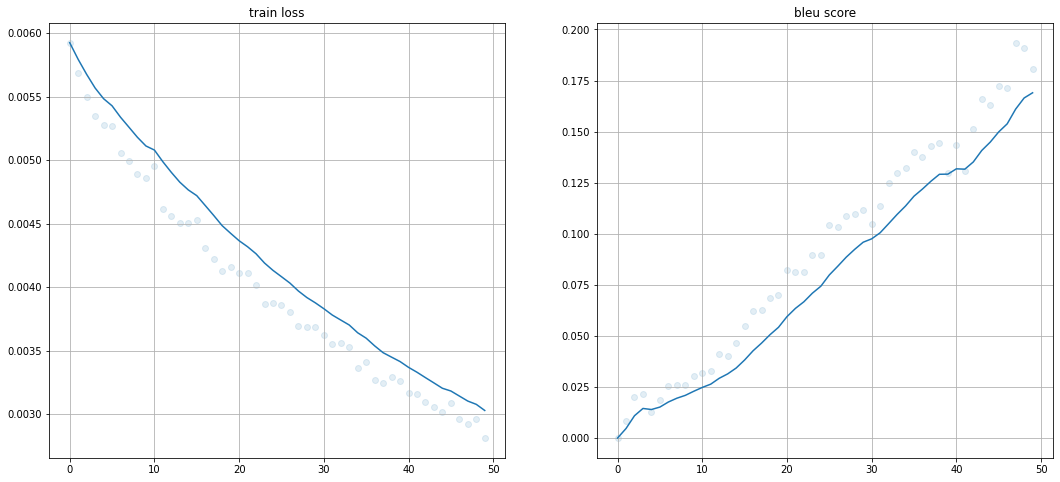

In [18]:
encoder = EncoderRNN(input_lang.n_words, EMB_SIZE).to(device)
decoder = DecoderRNN(EMB_SIZE, output_lang.n_words).to(device)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE)

criterion = nn.NLLLoss()

rnn_loss_array, rnn_bleu_array = train_full_set_rnn(
    encoder,
    decoder,
    encoder_optimizer,
    decoder_optimizer,
    criterion,
    teacher_forcing_proba=0.0,
    batch_size=BATCH_SIZE)

## 2. Реализовать модель машинного перевода с трансформерами вместо рекуррентных моделей. Можно использовать 1 слой трансформера на этапе кодирования и 1 на этапе декодирования. Обучить с таким же критерием остановки модель RNN, как и в пункте 2 на тех же данных.  

**7 баллов**

### 2.1. Data preprocessing

- Sentence preprocessing is done according to the format in which sentences need to be fed into the transformer, so aside bos and eos token we include a padding token (different from eos) and an unk token for OOV tokens.
- Aside of that, instead of just tokenizing with `str.split(' ')` we choose to tokenize the sentences in a more meaningful way with the tokenizers provided by `spaCy` (`ru_core_news_sm` for russian and `en_core_web_sm` for english). We didn't do this with the RNN model, because these tokenizers usually lead to longer sentences $\implies$ longer time steps in training a RNN $\implies$ higher change of suffering from the vanishing gradient problem.

In [19]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence as torch_pad_sequence
from typing import Iterable, List
import re
import spacy.cli
from sklearn.model_selection import train_test_split

from torch import Tensor
from torch.nn import Transformer
import math

In [20]:
spacy.cli.download("ru_core_news_sm")
spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 409.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.2.0
    Uninstalling typing_extensions-4.2.0:
      Successfully uninstalled typing_extensions-4.2.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires absl-py~=0.10, but you have absl-py 1.0.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.4 requires wrapt~=1.12.1, but you have wrapt 1.14.1 which is incompatible.
tensorflow-transform 1.8.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,<2.9,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.8.0 requires tensorflow<3,>=2.8.0, but you have tensorflow 2.6.4 which is incompatible.
rich 12.4.4 requires typing-extensions<5.0,>=4.0.0; python_version < "3.9", but you h

✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 14.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [21]:
SRC_LANGUAGE = 'ru'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='ru_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [22]:
token_transform['en']('Hello how are you?')

['Hello', 'how', 'are', 'you', '?']

In [23]:
token_transform['ru']('Привет как дела')

['Привет', 'как', 'дела']

In [24]:
# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

As above, we only train on sentences whose length lies between 10 and 50 tokens:

In [25]:
MAX_LENGTH = 50
MIN_LENGTH = 10

def filter_pairs(p):
  max_len_cond = len(p[0].split(' ')) <= MAX_LENGTH and len(p[1].split(' ')) <= MAX_LENGTH
  min_len_cond = len(p[0].split(' ')) >= MIN_LENGTH and len(p[1].split(' ')) >= MIN_LENGTH
  return max_len_cond and min_len_cond
  
def readLangs(filename, reverse=False):
    pairs_array = []
    lines = open(filename, encoding='utf-8').read().strip().split('\n')

    for line in lines:
      pair = tuple(map(normalizeString, line.split('\t')[:2]))

      if reverse:
        pair = pair[::-1]
      
      if filter_pairs(pair):
        pairs_array.append(pair)
    
    return pairs_array

pairs_array = readLangs('rus.txt', reverse=True)
print("Trimmed to %s sentence pairs" % len(pairs_array))
train_iter, valid_iter = train_test_split(pairs_array, test_size=0.33, random_state=42)

Trimmed to 13163 sentence pairs


In [26]:
train_iter[0]

('я могу только надеяться что со временем вы меня простите',
 'i can only hope that in time you ll forgive me')

In [27]:
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)


for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [28]:
vocab_transform['ru'].get_itos()[:10]

['<unk>', '<pad>', '<bos>', '<eos>', 'не', 'я', 'что', 'том', 'в', 'на']

In [29]:
vocab_transform['en'].get_itos()[:10]

['<unk>', '<pad>', '<bos>', '<eos>', 'i', 'to', 'you', 'tom', 't', 'the']

For the RNN model we use `MTDataset` to create the tokenized, numeralicalized sentences and create a `DataLoader` object with the `Dataset`. Here we define the functions outside and pass them to the DataLoader directly as argument to the `collate_fn` parameter.

In [30]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = torch_pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = torch_pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

### 2.2. Model implementation

In [31]:
# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


def test__TokenEmbedding():
  SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
  EMB_SIZE = 15
  BATCH_SIZE = 2
  

  mt_dataloder = DataLoader(train_iter, batch_size=BATCH_SIZE, drop_last=True, collate_fn=collate_fn)

  TEST_BATCH = next(iter(mt_dataloder))
  src = TEST_BATCH[0]

  embedder = TokenEmbedding(SRC_VOCAB_SIZE, EMB_SIZE)
  src_emb = embedder(src)


  assert src_emb.shape == torch.Size([src.shape[0], BATCH_SIZE, EMB_SIZE])
  print('All Ok!')

test__TokenEmbedding()

All Ok!


In [32]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))

        even_range = torch.arange(pos_embedding[:, 0::2].shape[1])
        odd_range = torch.arange(pos_embedding[:, 1::2].shape[1])

        pos_embedding[:, 0::2] = torch.sin(pos * den)[:, even_range]
        pos_embedding[:, 1::2] = torch.cos(pos * den)[:, odd_range]
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

def test__PositionalEncoding():
  SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
  EMB_SIZE = 15
  BATCH_SIZE = 2
  
  mt_dataloder = DataLoader(train_iter, batch_size=BATCH_SIZE, drop_last=True, collate_fn=collate_fn)

  TEST_BATCH = next(iter(mt_dataloder))
  src = TEST_BATCH[0]

  embedder = TokenEmbedding(SRC_VOCAB_SIZE, EMB_SIZE)
  pos_enc = PositionalEncoding(EMB_SIZE, dropout=0.1)
  src_emb = embedder(src)
  out = pos_enc(src_emb)

  assert src_emb.shape == torch.Size([src.shape[0], BATCH_SIZE, EMB_SIZE])
  print('All Ok!')

test__PositionalEncoding()

All Ok!


In [33]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)

    # Fill False with -inf and True with 0
    # -inf will be masked, but not 0
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# sr.shape = (sentence_length, batch_size)
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)

    # We need to see the whole source sentence, that's why we set them all to zero.
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)

    # src_mask.shape = (sentence_length, sentence_length)
    # tgt_mask.shape = (sentence_length, sentence_length)
    # src_padding_mask.shape = (batch_size, sentence_length)
    # tgt_padding_mask.shape = (batch_size, sentence_length)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [34]:
# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))

        
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

def test__Seq2SeqTransformer():

  SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
  TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
  EMB_SIZE = 15
  NHEAD = 1
  FFN_HID_DIM = 15
  BATCH_SIZE = 2
  NUM_ENCODER_LAYERS = 1
  NUM_DECODER_LAYERS = 1

  mt_dataloder = DataLoader(train_iter, batch_size=BATCH_SIZE, drop_last=True, collate_fn=collate_fn)

  TEST_BATCH = list(mt_dataloder)[0]

  model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
  
  model = model.to(device)

  src, tgt = TEST_BATCH[0].to(device), TEST_BATCH[1].to(device)
  tgt_input = tgt[:-1, :]

  src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

  logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

  assert logits.shape == torch.Size([tgt_input.shape[0], BATCH_SIZE, TGT_VOCAB_SIZE])
  print('All Ok!')

test__Seq2SeqTransformer()

All Ok!


### 2.3. Training code for one batch

In [35]:
def train_on_batch_transf(src, tgt, model, optimizer, criterion, batch_size):
  optimizer.zero_grad()
  # get all but the last word in each sentence in the batch as part of the training input
  tgt_input = tgt[:-1, :]
  # get all but the first word in each sentence in the batch as part of the training output
  tgt_out = tgt[1:, :]

  # src_mask.shape = (sentence_length, sentence_length)
  # tgt_mask.shape = (sentence_length, sentence_length)
  # src_padding_mask.shape = (batch_size, sentence_length)
  # tgt_padding_mask.shape = (batch_size, sentence_length)
  src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

  logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
  
  loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1)) / batch_size
  loss.backward()

  optimizer.step()
  
  return loss.item()


def test__train_on_batch_transf():
  SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
  TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
  EMB_SIZE = 15
  NHEAD = 1
  FFN_HID_DIM = 15
  BATCH_SIZE = 2
  NUM_ENCODER_LAYERS = 1
  NUM_DECODER_LAYERS = 1
  LEARNING_RATE = 1e-3
  mt_dataloder = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, drop_last=True)

  TEST_BATCH = list(mt_dataloder)[0]

  model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)
  

  model = model.to(device)
  criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  src, tgt = TEST_BATCH[0].to(device), TEST_BATCH[1].to(device)


  loss = train_on_batch_transf(src, tgt, model, optimizer, criterion, BATCH_SIZE)

  return loss

test__train_on_batch_transf()

4.297343730926514

Greedy search for evaluation (during training):

In [36]:
# function to generate output sequence using greedy algorithm
def greedy_decode_transf(model, src, src_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    # Call the encoder on src and src_mask
    # memory – the sequence from the last layer of the encoder
    memory = model.encode(src, src_mask)
    memory = memory.to(device)

    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):

        # mask target
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        
        
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)  # transpose for linear layer: from (seq_length, batch_size, emb_size) to (batch_size, seq_length, emb_size)
        
        # model.generator is the Linear layer at the end of the decoder.
        prob = model.generator(out[:, -1])

        # next_word = word index in the vocabulary
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    # at the end ys is a list of predicted tokens
    return ys

def greedy_evaluate_sample_transf(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    # at the end ys is a list of predicted tokens
    translated_idx = greedy_decode_transf(
        model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    
    translated_tokens = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(translated_idx.cpu().numpy()))

    return translated_tokens


def test__greedy_evaluate_sample_transf():
  SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
  TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
  EMB_SIZE = 15
  NHEAD = 1
  FFN_HID_DIM = 15
  NUM_ENCODER_LAYERS = 1
  NUM_DECODER_LAYERS = 1

  model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

  model = model.to(device)
  return greedy_evaluate_sample_transf(model, 'я хочу спать')


test__greedy_evaluate_sample_transf()

['<bos>',
 'superstitious',
 'words',
 'agent',
 'depend',
 'preparing',
 'dug',
 'dug',
 'dug',
 'dug']

In [37]:
def sentenceFromTensor_transf(src, tgt):
    
    batch_size = src.shape[1]

    input_list = []
    for i in range(batch_size):
      sent = vocab_transform[SRC_LANGUAGE].lookup_tokens(src[:, i].tolist())
      sent = list(filter(lambda x: x != '<bos>' and x != '<eos>' and x != '<pad>', sent))
      input_list.append(sent)

    target_list = []
    for i in range(batch_size):
      sent = vocab_transform[TGT_LANGUAGE].lookup_tokens(tgt[:, i].tolist())
      sent = list(filter(lambda x: x != '<bos>' and x != '<eos>' and x != '<pad>', sent))
      target_list.append(sent)

    return input_list, target_list
  

def test__sentenceFromTensor_transf():
  BATCH_SIZE = 2
  mt_dataloder = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, drop_last=True)

  TEST_BATCH = next(iter(mt_dataloder))
  src, tgt = TEST_BATCH[0], TEST_BATCH[1]

  input_sentences, target_sentences = sentenceFromTensor_transf(src, tgt)
  print(input_sentences)
  print(target_sentences)

test__sentenceFromTensor_transf()

[['я', 'могу', 'только', 'надеяться', 'что', 'со', 'временем', 'вы', 'меня', 'простите'], ['можешь', 'есть', 'что', 'угодно', 'при', 'условии', 'что', 'не', 'будешь', 'переедать']]
[['i', 'can', 'only', 'hope', 'that', 'in', 'time', 'you', 'll', 'forgive', 'me'], ['you', 'may', 'eat', 'anything', 'as', 'long', 'as', 'you', 'don', 't', 'eat', 'too', 'much']]


### 2.5. Training sanity check for training

Before training on the full set, let's check if the model and the built training loop produce the desired results (loss decreases and bleu score increases)

In [38]:
# Training hyperparameters (one batch only)
EPOCH_NUM = 300
LEARNING_RATE = 1e-3
SHOW_EVERY = 5
BATCH_SIZE = 8

# Tranformer hyperparameters
NUM_ENCODER_LAYERS = 1
NUM_DECODER_LAYERS = 1
EMB_SIZE = 256
NHEAD = 1
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
FFN_HID_DIM = 15

In [39]:
def train_single_batch_transf(
    model,
    optimizer,
    criterion,
    batch_size
):

  mt_dataloder = DataLoader(train_iter, batch_size=batch_size, collate_fn=collate_fn, drop_last=True)

  loss_array = []
  bleu_array = []

  #### TRAIN IN ON BATCH - BEGIN
  TEST_BATCH = next(iter(mt_dataloder))
  input_tensor, target_tensor = TEST_BATCH
  input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)

  input_sentences, target_sentences = sentenceFromTensor_transf(input_tensor, target_tensor)
  #### TRAIN IN ON BATCH - END

  ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

  for epoch in range(EPOCH_NUM):
    loss = train_on_batch_transf(input_tensor, target_tensor, model, optimizer, criterion, batch_size)

    if epoch % SHOW_EVERY == 0:
      loss_array.append(loss)
      translated_list = []

      for sentence in input_sentences:
        input_sent = " ".join(sentence)
        translated_sentence = greedy_evaluate_sample_transf(model, input_sent)
        translated_sentence = list(filter(lambda x: x!= '<bos>' and x != '<eos>', translated_sentence))
        translated_list.append(translated_sentence)

      ref_sentences = [[ref] for ref in target_sentences]
      score = bleu_score(translated_list, ref_sentences)
      bleu_array.append(score)

      clear_output(True)
      plt.figure(figsize=[18, 8])
      plt.subplot(1, 2, 1), plt.title('train loss'), plt.grid()
      plt.scatter(np.arange(len(loss_array)), loss_array, alpha=0.12)
      plt.plot(ewma(loss_array, span=10))

      plt.subplot(1, 2, 2), plt.title('bleu score'), plt.grid()
      plt.scatter(np.arange(len(bleu_array)), bleu_array, alpha=0.12)
      plt.plot(ewma(bleu_array, span=10))
      plt.show()


  for true, target, translated in zip(input_sentences, target_sentences, translated_list):
    print('Input:\t\t', " ".join(true))
    print('Gold:\t\t', " ".join(target))
    print('Translated:\t', " ".join(translated))
    print()

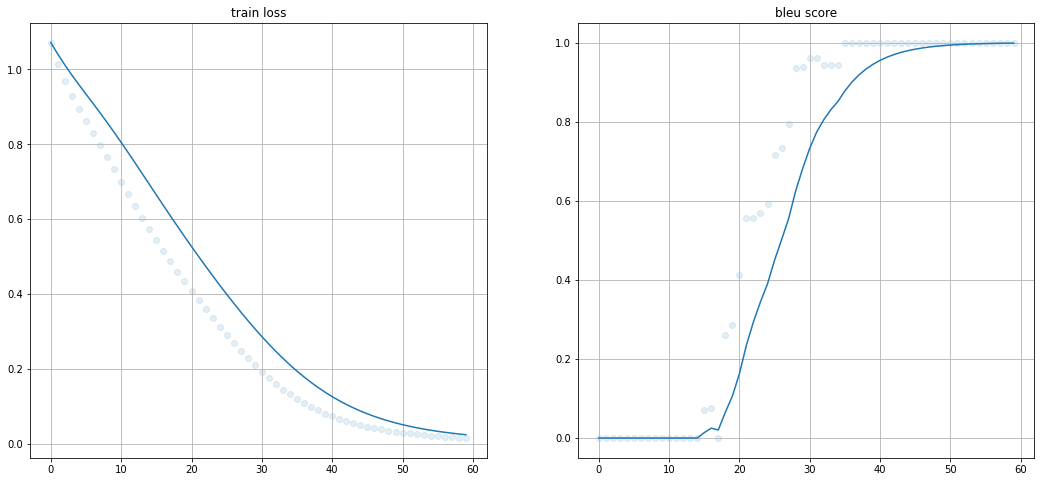

Input:		 я могу только надеяться что со временем вы меня простите
Gold:		 i can only hope that in time you ll forgive me
Translated:	 i can only hope that in time you ll forgive me

Input:		 можешь есть что угодно при условии что не будешь переедать
Gold:		 you may eat anything as long as you don t eat too much
Translated:	 you may eat anything as long as you don t eat too much

Input:		 поскольку я не получил ответа я написал ей ещё раз
Gold:		 since i didn t receive a reply i wrote to her again
Translated:	 since i didn t receive a reply i wrote to her again

Input:		 вы не знали что том всю неделю пробудет в бостоне
Gold:		 didn t you know tom was going to be in boston all week
Translated:	 didn t you know tom was going to be in boston all week

Input:		 я был бы очень благодарен если бы вы мне помогли
Gold:		 i d be very grateful if you d help me
Translated:	 i d be very grateful if you d help me

Input:		 пожалуй три самых популярных вкуса мороженого ванильный шоколадный и клубнич

In [40]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS, 
    NUM_DECODER_LAYERS, 
    EMB_SIZE,
    NHEAD, 
    SRC_VOCAB_SIZE, 
    TGT_VOCAB_SIZE, 
    FFN_HID_DIM)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

train_single_batch_transf(
    model,
    optimizer,
    criterion,
    batch_size=BATCH_SIZE)

All works fine. Let's train on the whole training set.

### 2.6. Transformer training on full set.

In [41]:
# Training hyperparameters (full set)
EPOCH_NUM = 50
LEARNING_RATE = 1e-3
SHOW_EVERY = 1
BATCH_SIZE = 128
# BATCH_SIZE = 8


# Tranformer hyperparameters
NUM_ENCODER_LAYERS = 1
NUM_DECODER_LAYERS = 1
EMB_SIZE = 256
NHEAD = 1
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
FFN_HID_DIM = 15

In [42]:
def train_full_set_transf(
    model,
    optimizer,
    criterion,
    batch_size
):

  mt_dataloder = DataLoader(train_iter, batch_size=batch_size, collate_fn=collate_fn, drop_last=True)

  ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values
  
  loss_array = []
  bleu_array = []

  for epoch in range(EPOCH_NUM):
    bar = Progbar(len(mt_dataloder))
    epoch_loss = 0
    
    for src, tgt in mt_dataloder:
      src = src.to(device)
      tgt = tgt.to(device)

      loss = train_on_batch_transf(src, tgt, model, optimizer, criterion, batch_size)

      epoch_loss += loss
      bar.add(1)
    
    if epoch % SHOW_EVERY == 0:
      input_sentences, target_sentences = sentenceFromTensor_transf(src, tgt)
      loss_array.append(epoch_loss / len(mt_dataloder))
      translated_list = []

      for sentence in input_sentences:
        input_sent = " ".join(sentence)
        translated_sentence = greedy_evaluate_sample_transf(model, input_sent)
        translated_sentence = list(filter(lambda x: x!= '<bos>' and x != '<eos>', translated_sentence))
        translated_list.append(translated_sentence)
    
      ref_sentences = [[ref] for ref in target_sentences]
      score = bleu_score(translated_list, ref_sentences)
      bleu_array.append(score)

      clear_output(True)
      plt.figure(figsize=[18, 8])
      plt.subplot(1, 2, 1), plt.title('train loss'), plt.grid()
      plt.scatter(np.arange(len(loss_array)), loss_array, alpha=0.12)
      plt.plot(ewma(loss_array, span=10))

      plt.subplot(1, 2, 2), plt.title('bleu score'), plt.grid()
      plt.scatter(np.arange(len(bleu_array)), bleu_array, alpha=0.12)
      plt.plot(ewma(bleu_array, span=10))
      plt.show()

  return loss_array, bleu_array

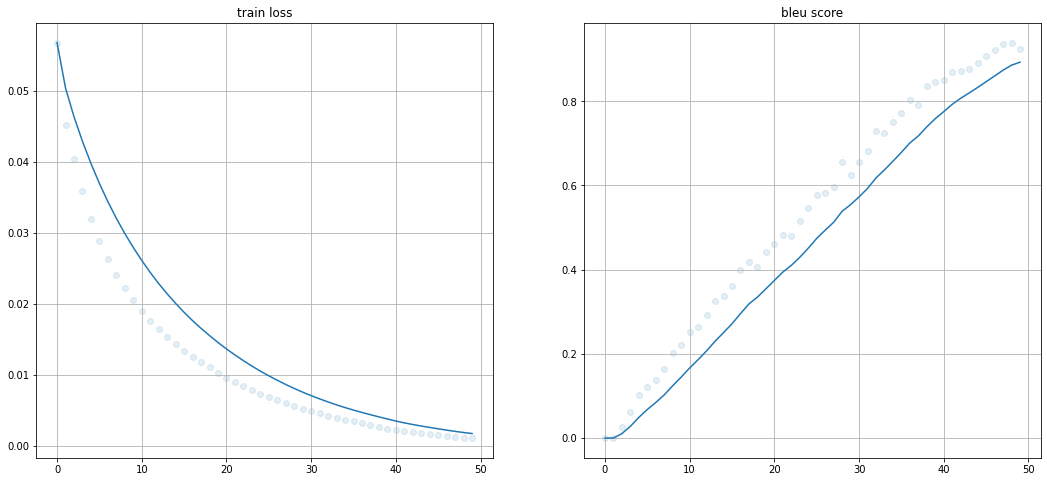

In [43]:
model = Seq2SeqTransformer(
    NUM_ENCODER_LAYERS, 
    NUM_DECODER_LAYERS, 
    EMB_SIZE,
    NHEAD, 
    SRC_VOCAB_SIZE, 
    TGT_VOCAB_SIZE, 
    FFN_HID_DIM)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
        
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

loss_array_transf, bleu_array_transf = train_full_set_transf(
    model,
    optimizer,
    criterion,
    batch_size=BATCH_SIZE)

### 3. Сравнить 2 модели(RNN vs Transformers) по скорости сходимости и достигнутому качеству. Оформить выводы по процессу и результату обучения. 

**3 балла**

Disclaimer:
- We note that the loss function for the RNN model is `NLLLoss` and for the Transformer is `CrossEntropyLoss`. Since the `NLLLoss` is preceded by a `LogSoftMax` activation, they are actually the same, and don't invalidate the analysis below.

In [44]:
ewma = lambda x, span: pd.DataFrame({'x': x})['x'].ewm(span=span).mean().values

def generate_plot(
    losses, 
    bleus, 
    labels
):

  f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15, 6))
  ax1.grid()
  ax2.grid()
  for loss, bleu, label_ in zip(losses, bleus, labels):
    ax1.scatter(np.arange(len(loss)), loss, alpha=0.12)
    ax1.plot(ewma(loss, span=10), label=label_)
    ax1.legend(loc='upper right')
  
    ax2.scatter(np.arange(len(bleu)), bleu, alpha=0.12)
    ax2.plot(ewma(bleu, span=10), label=label_)
    ax2.legend(loc='lower right')

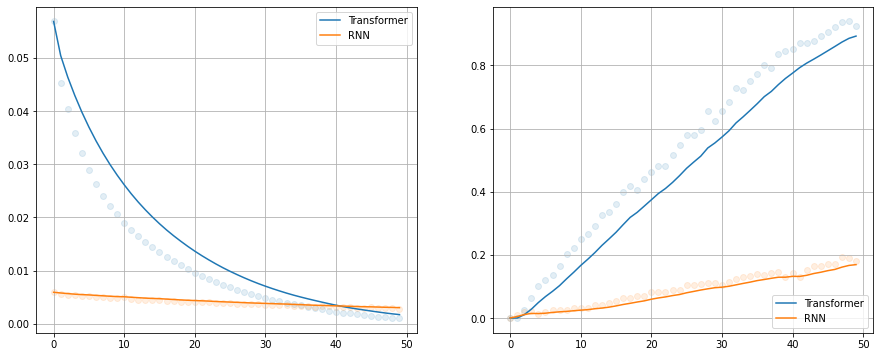

In [45]:
losses = [loss_array_transf, rnn_loss_array]
bleus = [bleu_array_transf, rnn_bleu_array]
labels = ['Transformer', 'RNN']

generate_plot(
    losses, 
    bleus, 
    labels)

In [46]:
print('Transformer')
print('\tBLEU score after 50 epochs: ', bleu_array_transf[-1])
print('\tLoss value after 50 epochs: ', loss_array_transf[-1])
print('RNN')
print('\tBLEU score after 50 epochs: ', rnn_bleu_array[-1])
print('\tLoss value after 50 epochs: ', rnn_loss_array[-1])

Transformer
	BLEU score after 50 epochs:  0.9251101016998291
	Loss value after 50 epochs:  0.0010903877658112085
RNN
	BLEU score after 50 epochs:  0.18045879095984513
	Loss value after 50 epochs:  0.0028108595048680026


**<font color=blue>Observations:</font>**

- _Performance:_ The transformer-based model
    - performs better that the RNN-based one. (BLEU score of 0.93 vs 0.18).
    - shows a better convergence towards the optimum.
    
    
- _Convergence speed:_, The RNN training loss is 1) small from the beginning and 2) outperformed by that of the transformer on the last training epochs (it slowly moves towards the optimum). Both 1) are 2) are signs that the model suffered from the vanishing gradient problem. This shows the drawbacks of a RNN-based seq2seq model discussed in class: 

    - The last hidden vector of the encoder is a bottleneck for transfering information from long sentences to the decoder.
    - The longer the sequences, the longer the (time) steps carried out during backpropagation and the more the gradient is damped towards zero.

### 4. Добавить в процесс обучения модели NMT на трансформерах  teacher forcing. Сравнить итоговое качество c моделью из пункта **3**. Оформить выводы по результату. 

**3 балла**

We try teacher forcing on the RNN-based model (on the Transformer model we already feed the whole target sentence to the decoder, so it can be considered as including teacher forcing already).

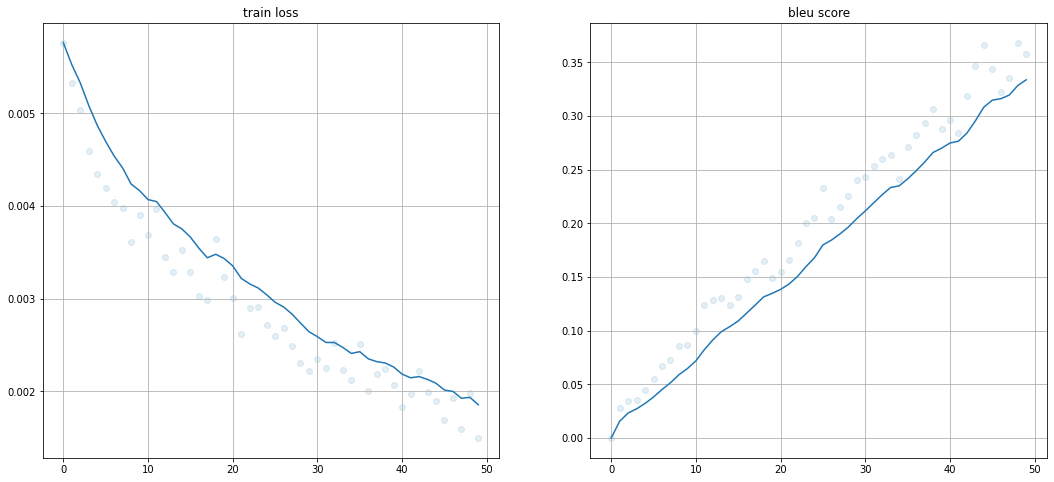

In [47]:
encoder_teachf = EncoderRNN(input_lang.n_words, EMB_SIZE).to(device)
decoder_teachf = DecoderRNN(EMB_SIZE, output_lang.n_words).to(device)

encoder_teachf_optimizer = optim.Adam(encoder_teachf.parameters(), lr=LEARNING_RATE)
decoder_teachf_optimizer = optim.Adam(decoder_teachf.parameters(), lr=LEARNING_RATE)

criterion_teachf = nn.NLLLoss()

rnn_teachf_loss_array, rnn_teachf_bleu_array = train_full_set_rnn(
    encoder_teachf,
    decoder_teachf,
    encoder_teachf_optimizer,
    decoder_teachf_optimizer,
    criterion_teachf,
    teacher_forcing_proba=0.6,
    batch_size=BATCH_SIZE)

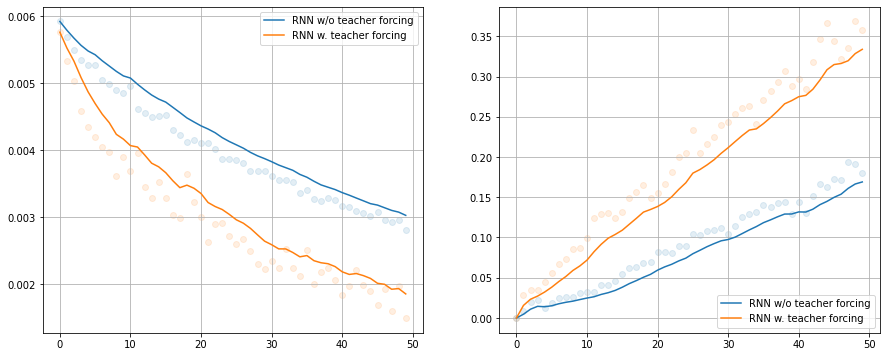

In [48]:
losses = [rnn_loss_array, rnn_teachf_loss_array]
bleus = [rnn_bleu_array, rnn_teachf_bleu_array]
labels = ['RNN w/o teacher forcing', 'RNN w. teacher forcing']

generate_plot(
    losses, 
    bleus, 
    labels)

**<font color=blue>Observations:</font>**

- The model trained with teacher forcing (TF) converges faster and as a consequence shows a better score that the model without TF.
- Even though the model performs better. it still suffers from the vanishing gradient problem, as the initial value for the loss function (at `epoch=0`) shows, for the same reasons indicated above when comparing the RNN model to the Transformer.

### 5. Для улучшения качества предсказания, реализуйте beam search для b = 3. Как улучшится качество перевода BLEU с добавлением этого метода? Оформить выводы по результату. 

**4 балла**

Let's try doing beam search with the best model, that is, with the transformer. For the implementation we follow the pseudocode from [Clara Meister, Tim Vieira, Ryan Cotterell; Best-First Beam Search](https://direct.mit.edu/tacl/article/doi/10.1162/tacl_a_00346/96473/Best-First-Beam-Search). In this implementation, the authors assumed a monotic scoring function with respect to the sentence length. To match that condition we just use the output of linear layer on top of the transformer (`model.generator`) as this function and compute subsequent scores by simple addition.

We evaluate the model on the validation set.

In [49]:
def beam_search_decode_transf(model, src, src_mask, max_len, start_symbol, k):
    src = src.to(device)
    src_mask = src_mask.to(device)

    # Call the encoder on src and src_mask
    # memory – the sequence from the last layer of the encoder
    memory = model.encode(src, src_mask)
    memory = memory.to(device)

    # Tensor for BOS_IDX
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    B = [(0.0, ys)]
    for i in range(max_len-1):

      B_next = []

      for cum_score, ys in B:

        if ys[-1].item() == EOS_IDX:
          B_next.append((cum_score, ys))
          continue

        # mask target
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)  # transpose for linear layer: from (seq_length, batch_size, emb_size) to (batch_size, seq_length, emb_size)

        # model.generator is the Linear layer at the end of the decoder.
        prob = model.generator(out[:, -1])

        topv, topi = prob.topk(k)

        for j in range(k):
          next_word = topi[:, j].item()
          next_score = topv[:, j].item()

          next_cum_score = cum_score + next_score
          new_ys = torch.cat([ys,
                              torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
          
          B_next.append((next_cum_score, new_ys))
        
      B_sorted = sorted(B_next, key=lambda t: str(t[0]) + '_' + str(t[1]), reverse=True)

      B = [(k1, v1) for i, (k1, v1) in enumerate(B_sorted) 
                        if not any(k1 == k2 and torch.equal(v1, v2) for k2, v2 in B_sorted[i+1:])][:k]

    # at the end ys is a list of predicted tokens
    return B
  
def beam_search_evaluate_sample_transf(model: torch.nn.Module, src_sentence: str, k):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    # at the end ys is a list of predicted tokens
    beamed_k_translated_idx = beam_search_decode_transf(model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX, k=k)
    translated_idx = max(beamed_k_translated_idx)[1]

    translated_tokens = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(translated_idx.cpu().numpy()))

    return translated_tokens


def test__beam_search_decode_transf(k=3):
  print('test__beam_search_decode()')
  SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
  TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
  EMB_SIZE = 15
  NHEAD = 1
  FFN_HID_DIM = 15
  NUM_ENCODER_LAYERS = 1
  NUM_DECODER_LAYERS = 1

  model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

  model = model.to(device)

  model.eval()

  src_sentence = 'я хочу спать'

  src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
  num_tokens = src.shape[0]
  src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

  # at the end ys is a list of predicted tokens
  beamed_k_translated_idx = beam_search_decode_transf(model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX, k=k)

  print(f'Beam size: {k}')
  for score, translated_idx in beamed_k_translated_idx:
    translated_tokens = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(translated_idx.cpu().numpy()))

    print(f"Score: {score}: \t Sentence: {' '.join(translated_tokens)}")


def test__beam_search_evaluate_sample_transf(k=3):
  print('test__evaluate_beam_search_sample():')
  SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
  TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
  EMB_SIZE = 15
  NHEAD = 1
  FFN_HID_DIM = 15
  NUM_ENCODER_LAYERS = 1
  NUM_DECODER_LAYERS = 1

  model = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

  model = model.to(device)
  return beam_search_evaluate_sample_transf(model, 'я хочу спать', k=k)


test__beam_search_decode_transf(k=4)
print('**************************')
test__beam_search_evaluate_sample_transf(k=3)

test__beam_search_decode()
Beam size: 4
Score: 18.054925322532654: 	 Sentence: <bos> recently during arteries business charm mirror during bikinis childrearing
Score: 17.999484181404114: 	 Sentence: <bos> recently during city rabies flute line yesterday rabies during
Score: 17.972368955612183: 	 Sentence: <bos> recently during arteries business charm mirror during arteries direct
Score: 17.947111129760742: 	 Sentence: <bos> recently during arteries business charm mirror during arteries business
**************************
test__evaluate_beam_search_sample():


['<bos>',
 'whether',
 'history',
 'per',
 'essential',
 'so',
 'box',
 'overtime',
 'per',
 'essential']

In [50]:
def calculate_bleu(model, sample_evaluator):
  candidates_sentences = []
  reference_sentences = []

  valid_dataloader = DataLoader(valid_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn, drop_last=True)

  for src, tgt in valid_dataloader:
    src, tgt = src.to(device), tgt.to(device)
    input_sentences, target_sentences = sentenceFromTensor_transf(src, tgt)

    translated_list = []
    for sentence in input_sentences:
          input_sent = " ".join(sentence)
          translated_sentence = sample_evaluator(model, input_sent)
          translated_sentence = list(filter(lambda x: x!= '<bos>' and x != '<eos>', translated_sentence))
          translated_list.append(translated_sentence)

    ref_sentences = [[ref] for ref in target_sentences]

    candidates_sentences.extend(translated_list)
    reference_sentences.extend(ref_sentences)
    
  return bleu_score(candidates_sentences, reference_sentences)

In [51]:
from functools import partial

evaluate_bm_sample = partial(beam_search_evaluate_sample_transf, k=3)
calculate_bleu(model, evaluate_bm_sample)

0.36104029417037964

In [53]:
calculate_bleu(model, greedy_evaluate_sample_transf)

0.2447044551372528

**<font color=blue>Observations:</font>**

- Beam search improves predictions when compared to the traditional greedy approach which, as experience demonstrates, is often the case when using both heuristics to approximate exact search.
- We didn't time the evaluation process on the validation set, but beam search took longer than simple greedy search, even for `k=3`. This show the trade-off between time and trying to find the exact solution by checking even a subset of the all possible combinations/predictions.
- The validation score in both cases (greedy/beam search) is way below the training score (of 0.93), which shows that the model is clearly overfitting the training set.